In [1]:
from math import *
import numpy as np
import matplotlib.pyplot as pt
%matplotlib inline

Here we use the Implicit method to solve the parabolic PDE (Black-Scholes equation) for $v(t,x) \in \mathbb{R}$ subject to time dependent Dirichlet BC's and initial condition:


$\large\frac{\partial v}{\partial t}$ $ - \frac{1}{2}\sigma^2 x^2 $$ \large\frac{\partial^2 v}{\partial x^2}$$ - rx $$\large{\frac{\partial v}{\partial x}}$$ + rv = 0 \space \space \text{for}\space t \in (0,T], \space x \in (0,R)\\$

$
v(t,0)=f_0(t),\\
v(t,R)=f_R(t),\\
U(0,x)=g(x)\\
$


with $\sigma>0$ (constant volatility), $r>0$ (interest rate), $T>0$, $R>0$, $f_0: (0,T] \rightarrow \mathbb{R}$, $f_R: (0,T] \rightarrow \mathbb{R}$, and $g: \mathbb{R} \rightarrow \mathbb{R}$ (pay-off function).

The solution $v(t, x)$ represents the value of a European option with maturity time $T$, at time-to-maturity $t$ and spot price $x$.

In [2]:
# Parameters:
Nx = 10 # Number of points in the space grid.
Nt = 100 # Number of points in the time grid.
r = 0 # Interest rate
sigma = 0.5 # Volatility
T = 5 # Final time
K = 100 # Strike Price
R = 3*K # Artificial limit of asset price.

In [3]:
def plot_sol(xmesh, u_computed, l_BC, r_BC, u_true=None):
    """
    A function that plots the approximate 
    computed solution Uh v.s. the true solution U, 
    for a single time step.
    """
    # Assembre complete solution with BCs
    sol = np.zeros(Nx+1)
    sol[0] = l_BC
    sol[1:-1] = u_computed
    sol[-1] = r_BC
    
    fig = pt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.plot(xmesh, sol, 'ro', label = 'computed')
    if(u_true is not None): ax.plot(xmesh, u_true, 'b-', label = 'true')
    ax.set_title(r"Black Scholes Equation @ time: "+str(t))
    ax.legend(loc='upper left')
    ax.set_xlabel('Asset Price')
    ax.set_ylabel('u(x,'+str(t)+') state') 
    
def solveTridiagonal(ld, d, ud, rhs):
    n = len(d)
    delta = d.copy();
    f = rhs.copy();
    
    #Elimination Stage.
    for i in range(1, n):
        delta[i] = delta[i] - ud[i-1]*ld[i-1]/delta[i-1];
        f[i] = f[i] - f[i-1]*ld[i-1]/delta[i-1];
    

    # Backsolve stage
    rhs[n-1] = f[n-1]/delta[n-1];
    for i in reversed(range(n-1)):
        rhs[i] = (f[i]  - ud[i]*rhs[i+1])/delta[i];

Small functions needed for the true solution.

In [4]:
def d_minus(t,x):
    if (t == 0 or x==0 or x==K): return -np.inf
    return ( 1/(sigma*sqrt(t)) )*( log(x/K) + ( r - (sigma**2)/2 )*t )
    
def d_plus(t,x):
    if(t==0): return np.inf
    elif(x==K or x==0): return -np.inf
    return ( 1/(sigma*sqrt(t)) )*( log(x/K) + ( r + (sigma**2)/2 )*t )
    
def m_erfc(x):
    """
    Vector valued error function.
    """
    if isinstance(x, (float, int)): # Scalar input
        return erfc(x)
    else: # Vector input
        result = np.zeros(x.size)
        for i in range(x.size):
            result[i] = erfc(x[i])
        return result
    
def stdCumNormal(d):
    return 0.5*m_erfc( -( d/sqrt(2)) )

Boundary and Initial Condition Functions

In [5]:
# Left Boundary Condition Function f0(t)
def f_0(t):
    return K*exp(-r*t)

# Right Boundary Condition Function fR(t)
def f_R(t):
    return true_sol(t, R)

# Initial condition function g(x) 
def g(x): 
    if isinstance(x, (float, int)): # Scalar input 
        return K-x if (x<K) else 0
    else: # Vector input
        result = np.zeros(x.size)
        for i in range(x.size):
            if x[i]<K: result[i] = K-x[i]
        return result

In [6]:
def const_true_sol(t, x):
    if(t==0): return g(x)
    return K*exp(-r*t)*stdCumNormal(-d_minus(t,x)) - x*stdCumNormal(-d_plus(t,x))

# True solution function
def true_sol(t, x):
    if isinstance(x, (float, int)): # Scalar input
        return const_true_sol(t, x)
    else: # Vector input
        result = np.zeros(x.size)
        for i in range(x.size):
            result[i] = const_true_sol(t, x[i])
        return result

In [7]:
# Meshes
xs = np.linspace(0,R, Nx+1)
h = xs[1] - xs[0]
ts = np.linspace(0,T, Nt+1)
dt = ts[1] - ts[0]
inner_xs = xs[1:-1]

In [8]:
true_sol(0.5, xs)

array([  1.00000000e+02,   7.00016210e+01,   4.08989881e+01,
         1.89108302e+01,   7.41509442e+00,   2.67846861e+00,
         9.38911279e-01,   3.28648825e-01,   1.16621142e-01,
         4.22806634e-02,   1.57201941e-02])

Semi-Implicit Discretization

In [9]:
# Coefficients for tridiagonal matrix
alpha = (sigma**2)*dt
beta = r*dt

ldiag = np.zeros(Nx-2)
mdiag = np.zeros(Nx-1)
udiag = np.zeros(Nx-2)

l_0 = -0.5*alpha
for n in range(1, Nx-1):
    ldiag[n-1] = -0.5*alpha*( (n+1)**2 ) # Lower diagonal vector
    mdiag[n-1] = 1 + beta + beta*n + alpha*(n**2) # Main diagonal vector
    udiag[n-1] = -( beta*n + 0.5*alpha*(n**2) ) # Upper diagonal vector. 
mdiag[-1] = 1 + beta + beta*(Nx-1) + alpha*( (Nx-1)**2 )
u_R = -( beta*(Nx-1) + 0.5*alpha*((Nx-1)**2) )

In [10]:
print(ldiag)
print(mdiag)
print(udiag)

[-0.025   -0.05625 -0.1     -0.15625 -0.225   -0.30625 -0.4     -0.50625]
[ 1.0125  1.05    1.1125  1.2     1.3125  1.45    1.6125  1.8     2.0125]
[-0.00625 -0.025   -0.05625 -0.1     -0.15625 -0.225   -0.30625 -0.4    ]


Fully Implicit Discretization.

In [11]:
mdiag.size

9


t = 0.0
uh_b:[ 70.  40.  10.   0.   0.   0.   0.   0.   0.]
l_BC: 100.0
r_BC:8.367495826846484e-23
u_R: -0.50625
uh_a:[  7.06250000e+01   4.00000000e+01   1.00000000e+01   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   4.23604476e-23]

t = 0.05
uh_b:[  7.00001558e+01   4.00252320e+01   1.10595872e+01   9.31048337e-01
   1.12992837e-01   1.80914908e-02   3.59677076e-03   8.46608323e-04
   2.12966690e-04]
l_BC: 100.0
r_BC:6.993631220683027e-12
u_R: -0.50625
uh_a:[  7.06251558e+01   4.00252320e+01   1.10595872e+01   9.31048337e-01
   1.12992837e-01   1.80914908e-02   3.59677076e-03   8.46608323e-04
   2.12966694e-04]

t = 0.1
uh_b:[  7.00006048e+01   4.00730617e+01   1.20587071e+01   1.80648327e+00
   3.08608798e-01   6.26764767e-02   1.48996485e-02   4.03017631e-03
   1.11962408e-03]
l_BC: 100.0
r_BC:3.900869250398285e-08
u_R: -0.50625
uh_a:[  7.06256048e+01   4.00730617e+01   1.20587071e+01   1.80648327e+00
   3.08608798e-01   6.26764767e-02   1.

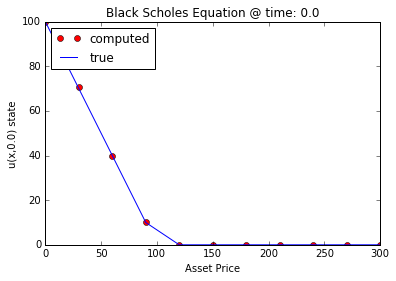

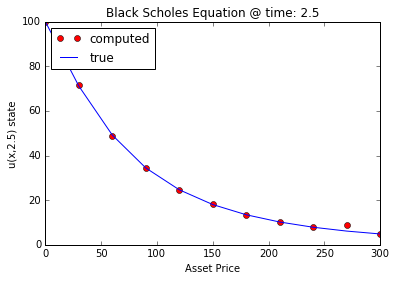

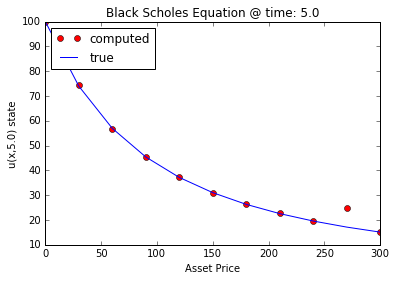

In [28]:
uh = g(inner_xs) # Initial Condition
for t in ts:
    
    print("")
    print("t = "+str(t))
    l_BC = f_0(t+dt)
    r_BC = f_R(t+dt)
    
    print("uh_b:"+str(uh))
    print("l_BC: "+str(l_BC))
    print("r_BC:"+str(r_BC))
    
    
    uh[0] = uh[0] - l_0*l_BC # Include Left BC
    uh[-1] = uh[-1] - u_R*r_BC # Include Right BC
    
    print("u_R: "+str(u_R))
 
    print("uh_a:"+str(uh))
    if(t==0 or t == T/2 or t==T):
        u_true = true_sol(t, xs)
        plot_sol(xs, uh, l_BC, r_BC, u_true)
           
    solveTridiagonal(ldiag, mdiag, udiag, uh) 

In [31]:
d = [4,4,4,4]
ld = [1,1,1]
ud = [1,1,1]
rhs = [6, 12, 18, 19]
solveTridiagonal(ld, d, ud, rhs)
print(rhs)

[1.0, 2.0, 2.9999999999999996, 4.0]


In [40]:
A1=np.diag(d)
A2 = np.diag(ld, -1)
A3 = np.diag(ud, 1)

In [43]:
A = A1+A2+A3
print(A.dot(rhs))

[  6.  12.  18.  19.]


In [26]:
d2 = np.array([1,2,3,4])
len(d2)

4

In [21]:
n = 4;
for i in reversed(range(n-1)):
    print(i)
    
    #for(int i=n-2; i>=0; i--):

2
1
0


In [34]:
true_sol(dt, R)

8.367495826846484e-23